# Example Classifier Walkthrough

Adapted from Google Keras code example [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

 - Load libraries
 - Getting the data
 - Preprocessing
    - Standard image size
    - Splitting to train/test
 - Train a CNN and evaluate the results
 - Try the model on a new data source

 ## Remember first
 1. Activate a virtual environment `conda env` or `source .venv/bin/activate`
 2. `pip install -r requirements.txt` 

In [ ]:
# Install required packages
%pip install -q numpy matplotlib tensorflow torch torchvision
%reset -f

In [23]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
# import pydot # NOTE: need graphviz installed in the system
import hashlib
import shutil
import random
import glob
import pickle

# Create folders if they don't exist
%mkdir -p models
%mkdir -p checkpoints

# Constants
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 128
NUM_CLASSES = 3
ZIP_HASH = 'eedec42a8a363b8ff299a0f2d6eedadafc3af3e7'
MODEL_PATH = 'models/animals.keras'
HISTORY_PATH = MODEL_PATH + '.history.pkl'
REBUILD = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 2 for most warnings, 3 to suppress all warnings

# Get the image datasets

All image datasets will be stored in the `3-image_classification/animals` folder

## Option 1 - download zip from data.badmath.org

This is enabled in the next cell.

1. Download zip from data.badmath.org
2. Unzip folder
3. Delete zip file


## Option 2 - manual download from kaggle

This will take some downloading, unzipping, and moving/renaming files and folders.

### "Cat and Dog"
1. Download the dataset from https://www.kaggle.com/datasets/tongpython/cat-and-dog
2. Move the zip into the `animals` folder
3. Unzip it, I've called the folder `animals/cat_and_dog`
4. You should have images such as `animals/cat_and_dog/test_set/cats/cat.4001.jpg`

### "Animal Image Dataset"
1. Download the dataset from https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
2. Move the zip into the `animals` folder
3. Unzip it, I've called the folder `animals/animal_images`
4. You should have images such as `animals/animal_images/cats/cats_00001.jpg`


In [31]:
# Download image datasets

# Skip this if you've already got a directory called 'animals' (e.g. if you've run this before)
if not os.path.exists('animals'):
    # Use curl to download the zip if it's not already there
    if not os.path.exists('animals.zip'):
        !curl -L -o animals.zip 'https://data.badmath.org/animals.zip'
        
    
    hash = hashlib.sha1(open('animals.zip', 'rb').read()).hexdigest()
    if (hash == ZIP_HASH):
        print('✅ Download hash validated')
    else:
        raise Exception('❌ ERROR: Download hash does not match!')


    # Unzip the downloaded file into `animals`
    os.mkdir('animals')
    shutil.unpack_archive('animals.zip', 'animals')

    os.remove('animals.zip')

In [ ]:
# Check for corrupted images
train = 'animals/cat_and_dog/training_set/'
valid = 'animals/cat_and_dog/test_set/'
world = 'animals/animal_images/'

num_skipped = 0
for data_dir in (train, valid, world):
    for animal in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, animal)):
            folder_path = os.path.join(data_dir, animal)
            for fname in os.listdir(folder_path):
                fpath = os.path.join(folder_path, fname)
                try:
                    fobj = open(fpath, "rb")
                    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                finally:
                    fobj.close()

                if not is_jfif:
                    num_skipped += 1
                    print("Deleted %s" % fpath)
                    # Delete corrupted image
                    os.remove(fpath)


print("Deleted %d images" % num_skipped)

Found 8005 files belonging to 3 classes.
Found 2023 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


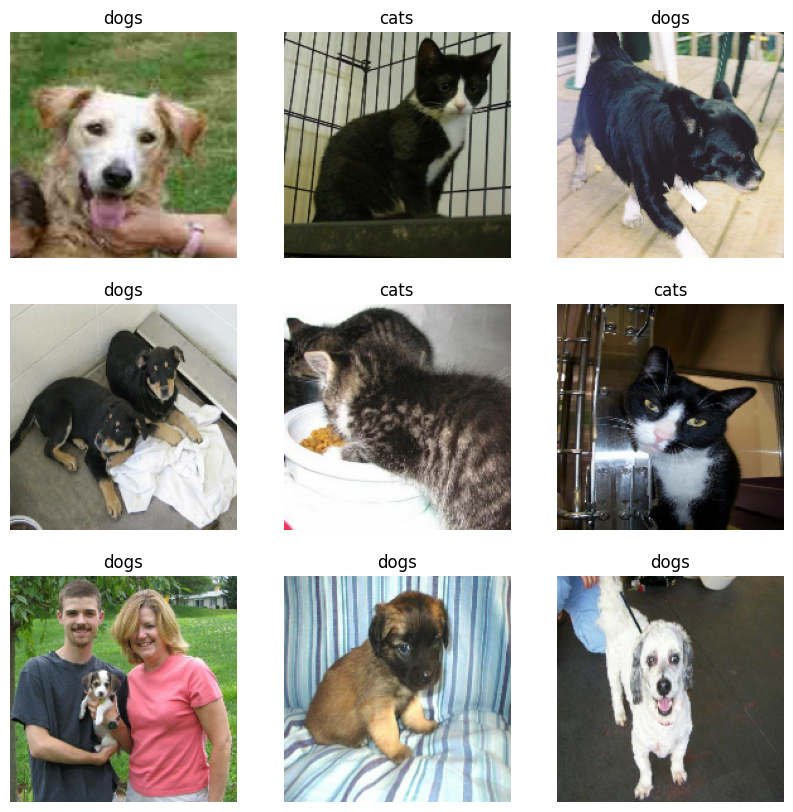

In [33]:
# Set the class names
class_names = os.listdir(train)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train,
    labels='inferred',
    subset=None,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
train_classes = train_ds.class_names
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid,
    labels='inferred',
    subset=None,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_classes = valid_ds.class_names
valid_ds = valid_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))


world_ds = tf.keras.utils.image_dataset_from_directory(
    world,
    labels='inferred',
    subset=None,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
world_classes = world_ds.class_names
world_ds = world_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))

# Show 3 images from each class in the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_classes[tf.argmax(labels[i])])
        plt.axis("off")


In [ ]:
# Find the minimum and maximum dimensions of images in the training set
min_height = 9999
min_width = 9999

for images, labels in train_ds:
    for image in images:
        height, width, _ = image.shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width

print("Minimum training dimensions:", min_height, "x", min_width)

# Find the minimum and maximum dimensions of images in the validation set
min_height = 9999
min_width = 9999

for images, labels in valid_ds:
    for image in images:
        height, width, _ = image.shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width

print("Minimum validation dimensions:", min_height, "x", min_width)

# Build a model

This code defines a convolutional neural network (CNN) using the Keras library. The network architecture consists of multiple blocks of separable convolutional layers, with residual connections between the blocks. The last layer is a dense layer with either sigmoid or softmax activation, depending on the number of classes. The model is created by calling the make_model function with the input shape and number of classes as arguments, and the resulting model is plotted using keras.utils.plot_model.

This is a simplified version of the Xception architecture (https://arxiv.org/abs/1610.02357).

Here is a quick description of the *layers* in our neural network:
 - `keras.Input(shape=input_shape)` creates an input layer with the specified input shape.

 - `layers.Rescaling(1.0 / 255)` rescales the input values by dividing them by 255.
 - `layers.Conv2D(128, 3, strides=2, padding="same")` creates a 2D convolutional layer with 128 filters, a kernel size of 3x3, a stride of 2, and same padding.
 - `layers.BatchNormalization()` normalizes the outputs of the previous layer to speed up training and reduce overfitting.
 - `layers.Activation("relu")` applies the ReLU activation function to the previous layer's outputs.
 - `layers.SeparableConv2D(size, 3, padding="same")` creates a depthwise separable convolutional layer with size filters, a kernel size of 3x3, and same padding.

 - `layers.MaxPooling2D(3, strides=2, padding="same")` applies max pooling to the previous layer's outputs, reducing their size by a factor of 2.
 
 - `layers.Conv2D(size, 1, strides=2, padding="same")` creates a 2D convolutional layer with size filters, a kernel size of 1x1, a stride of 2, and same padding.

 - `layers.add([x, residual])` adds the outputs of the previous layer and the residual layer.
 
 - `layers.GlobalAveragePooling2D()` calculates the average of each feature map in the previous layer's outputs.
 - `layers.Dropout(0.5)` randomly drops out 50% of the previous layer's outputs during training to reduce overfitting.
 - `layers.Dense(units, activation=activation)` creates a fully connected layer with units output nodes and the specified activation function.

In [ ]:
# Define a model
# This is a simplified version of the Xception architecture (https://arxiv.org/abs/1610.02357).
# a new layer is added to the model every time x is reassigned

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



In [ ]:
# Train the model

if REBUILD:
  model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)

  # Uncomment to show model summary plot
  # keras.utils.plot_model(model, show_shapes=True)

  epochs = 25

  callbacks = [
      keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.keras"),
  ]
  model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      # loss="binary_crossentropy",
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=valid_ds,
  )
  history_data = history.history

  # Save the model and history
  model.save(MODEL_PATH)
  with open(HISTORY_PATH, 'wb') as file:
    pickle.dump(history_data, file)
else:
  if not os.path.exists(MODEL_PATH):
    !curl -L -o {MODEL_PATH} 'https://data.badmath.org/animals.keras'
  if not os.path.exists(HISTORY_PATH):
    !curl -L -o {HISTORY_PATH} 'https://data.badmath.org/animals.keras.history.pkl'
  # Load the saved model and history
  model = keras.models.load_model(MODEL_PATH)
  with open(HISTORY_PATH, 'rb') as file:
    history_data = pickle.load(file)

In [ ]:
# Now with 100% more plotting!
# Plot the learning curves
acc = history_data['accuracy']
val_acc = history_data['val_accuracy']
loss = history_data['loss']
val_loss = history_data['val_loss']

epochs=25 #had to redefine? not reading?
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
val_loss, val_accuracy = model.evaluate(valid_ds)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_accuracy:.2f}")


In [ ]:
# Evaluate on the (cat, dog, panda) dataset
world_ds = world_ds.prefetch(buffer_size=32)
model.evaluate(world_ds)

In [ ]:
# Run inference on a new image
img = keras.preprocessing.image.load_img(
    world + 'pandas/panda_00016.jpg',
    target_size=IMAGE_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
class_index = tf.argmax(predictions, axis=1)[0]
score = float(predictions[0][class_index])

print(f"This image is a {class_names[class_index]} with a probability of {100 * score:.2f}%.")


In [ ]:
# How well does the model perform on the (cat, dog, panda) dataset? Especially on the pandas?!?

# Get list of all panda image file paths
panda_paths = glob.glob(world + 'pandas/*.jpg')

# Randomly select 9 panda images
sample_panda_paths = random.sample(panda_paths, 9)

# Create subplot for each image
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Loop through each image and its corresponding subplot
for i, path in enumerate(sample_panda_paths):
    img = keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    score = predictions[0]
    class_names = ['cat', 'dog']
    class_index = score.argmax()
    class_name = class_names[class_index]
    prob = score[class_index]
    axs[i//3][i%3].imshow(img_array[0]/255.)
    axs[i//3][i%3].set_title(f"{class_name}: {prob:.2f}")
    axs[i//3][i%3].axis('off')

plt.show()

## PyTorch Version

In [27]:
import logging

# Set the logging level
logging.getLogger().setLevel(logging.ERROR)  # Set to the desired level (e.g., logging.ERROR)
# Constants
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 128
NUM_CLASSES = 3
ZIP_HASH = 'eedec42a8a363b8ff299a0f2d6eedadafc3af3e7'
MODEL_PATH = 'models/animals.keras'
HISTORY_PATH = MODEL_PATH + '.history.pkl'
REBUILD = False

#### Set class names

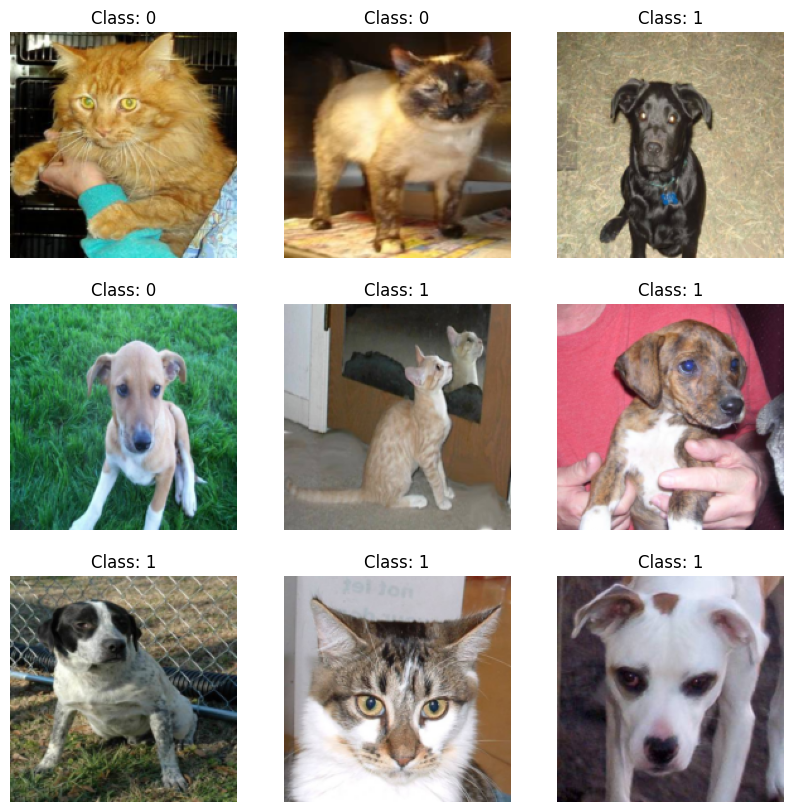

In [49]:
## Attempt 2.. 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 128
NUM_CLASSES = 3
ZIP_HASH = 'eedec42a8a363b8ff299a0f2d6eedadafc3af3e7'
MODEL_PATH = 'models/animals.pth'
HISTORY_PATH = MODEL_PATH + '.history.pkl'
REBUILD = False
torch.manual_seed(42)  # For reproducibility

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# Create PyTorch datasets
dataset_path = 'animals/cat_and_dog/'  # Change this path according to your dataset structure

# Define datasets
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Visualize the first batch of training data
for images, labels in train_loader:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(f"Class: {labels[i]}")
        plt.axis("off")
    break  # Stop after visualizing the first batch
plt.show()


Downloading data, no changes

In [50]:
# Download image datasets

# Skip this if you've already got a directory called 'animals' (e.g. if you've run this before)
if not os.path.exists('animals'):
    # Use curl to download the zip if it's not already there
    if not os.path.exists('animals.zip'):
        !curl -L -o animals.zip 'https://data.badmath.org/animals.zip'
        
    
    hash = hashlib.sha1(open('animals.zip', 'rb').read()).hexdigest()
    if (hash == ZIP_HASH):
        print('✅ Download hash validated')
    else:
        raise Exception('❌ ERROR: Download hash does not match!')


    # Unzip the downloaded file into `animals`
    os.mkdir('animals')
    shutil.unpack_archive('animals.zip', 'animals')

    os.remove('animals.zip')

In [51]:
import os
import shutil
import hashlib

train = 'animals/cat_and_dog/training_set/'
valid = 'animals/cat_and_dog/test_set/'
world = 'animals/animal_images/'

num_skipped = 0
for data_dir in (train, valid, world):
    for animal in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, animal)):
            folder_path = os.path.join(data_dir, animal)
            for fname in os.listdir(folder_path):
                fpath = os.path.join(folder_path, fname)
                try:
                    with open(fpath, "rb") as fobj:
                        is_jfif = b"JFIF" in fobj.peek(10)
                except Exception as e:
                    is_jfif = False

                if not is_jfif:
                    num_skipped += 1
                    print("Deleted %s" % fpath)
                    # Delete corrupted image
                    os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


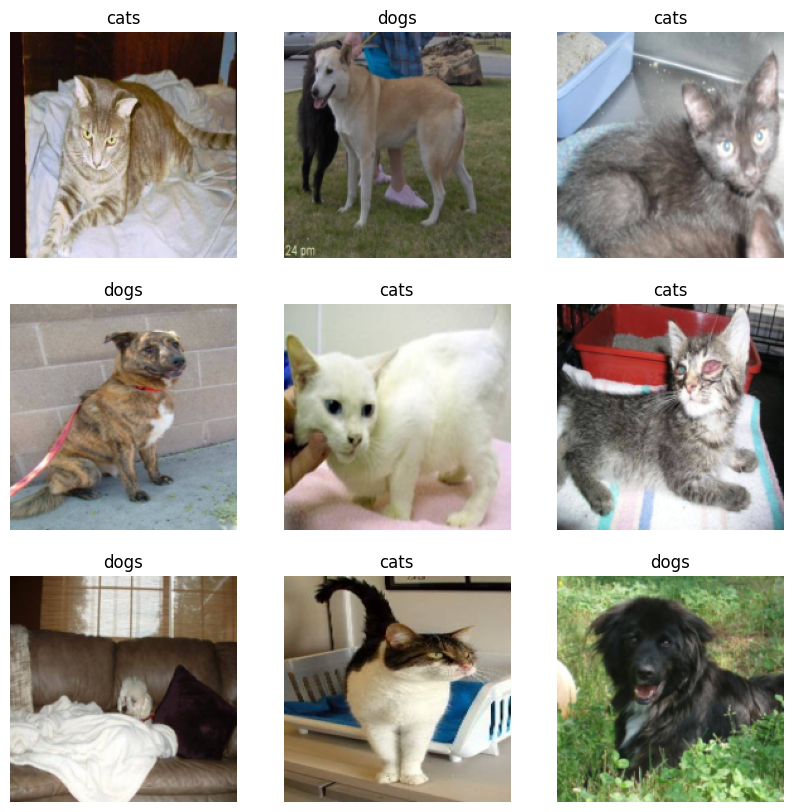

In [52]:
from torchvision import datasets, transforms
import torch

# Set the class names
class_names = os.listdir(train)

# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# Create PyTorch datasets
train_dataset = datasets.ImageFolder(train, transform=transform)
valid_dataset = datasets.ImageFolder(valid, transform=transform)
world_dataset = datasets.ImageFolder(world, transform=transform)

# Create PyTorch data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
world_loader = torch.utils.data.DataLoader(world_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Extract class names
train_classes = train_dataset.classes
valid_classes = valid_dataset.classes
world_classes = world_dataset.classes

# Visualize 3 images from each class in the training set
plt.figure(figsize=(10, 10))
for images, labels in train_loader:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(train_classes[labels[i]])
        plt.axis("off")
    break  # Stop after visualizing the first batch
plt.show()


In [53]:
# Find the minimum and maximum dimensions of images in the training set
min_height = 9999
min_width = 9999

for images, labels in train_loader:
    for image in images:
        height, width, _ = image.shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width

print("Minimum training dimensions:", min_height, "x", min_width)

# Find the minimum and maximum dimensions of images in the validation set
min_height = 9999
min_width = 9999

for images, labels in valid_loader:
    for image in images:
        height, width, _ = image.shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width

print("Minimum validation dimensions:", min_height, "x", min_width)


Minimum training dimensions: 3 x 180
Minimum validation dimensions: 3 x 180


## Defining the model

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class XceptionModel(nn.Module):
    def __init__(self, num_classes):
        super(XceptionModel, self).__init__()

        # Entry block
        self.rescaling = nn.functional.upsample
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.activation1 = nn.ReLU(inplace=True)

        self.previous_block_activation = None  # Set aside residual

        sizes = [256, 512, 728]
        for size in sizes:
            self.activation2 = nn.ReLU(inplace=True)
            self.separable_conv1 = SeparableConv2d(128, size, kernel_size=3, stride=1, padding=1)
            self.batch_norm2 = nn.BatchNorm2d(size)

            self.activation3 = nn.ReLU(inplace=True)
            self.separable_conv2 = SeparableConv2d(size, size, kernel_size=3, stride=1, padding=1)
            self.batch_norm3 = nn.BatchNorm2d(size)

            self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            # Project residual
            self.residual = nn.Conv2d(128, size, kernel_size=1, stride=2, padding=1)

        self.separable_conv3 = SeparableConv2d(728, 1024, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(1024)
        self.activation4 = nn.ReLU(inplace=True)

        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)

        if num_classes == 2:
            self.activation = nn.Sigmoid()
            self.fc = nn.Linear(1024, 1)
        else:
            self.activation = nn.Softmax(dim=1)
            self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Entry block
        x = self.rescaling(x, scale_factor=1.0 / 255)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation1(x)

        self.previous_block_activation = x  # Set aside residual

        sizes = [256, 512, 728]
        for size in sizes:
            x = self.activation2(x)
            x = self.separable_conv1(x)
            x = self.batch_norm2(x)

            x = self.activation3(x)
            x = self.separable_conv2(x)
            x = self.batch_norm3(x)

            x = self.max_pooling(x)

            # Project residual
            residual = self.residual(self.previous_block_activation)
            x = x + residual  # Add back residual
            self.previous_block_activation = x  # Set aside next residual

        x = self.separable_conv3(x)
        x = self.batch_norm4(x)
        x = self.activation4(x)

        x = self.global_avg_pooling(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        x = self.activation(x)

        return x

# Create an instance of the XceptionModel
num_classes = 3  # Change accordingly
model = XceptionModel(num_classes)

In [57]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have a PyTorch-compatible dataset (train_loader, valid_loader) and model (model) defined

if REBUILD:
    model = XceptionModel(num_classes)  # Assuming XceptionModel is defined
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()  # Use appropriate loss based on your task

    epochs = 25
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = correct / total
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {valid_loss}, Accuracy: {accuracy}")

    # Save the model
    torch.save(model.state_dict(), MODEL_PATH)

else:
    if not os.path.exists(MODEL_PATH):
        !curl -L -o {MODEL_PATH} 'https://data.badmath.org/animals.pth'
    # Load the saved model
    model = XceptionModel(num_classes)  # Assuming XceptionModel is defined
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()


UnpicklingError: invalid load key, 'H'.

In [58]:
print(MODEL_PATH)

models/animals.pth
